In [1]:
import torch
import json
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
from peft import LoraConfig, get_peft_model

/home/tobias/ui-rl/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
processor = AutoProcessor.from_pretrained("ByteDance-Seed/UI-TARS-1.5-7B")
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "ByteDance-Seed/UI-TARS-1.5-7B", 
    device_map="cuda", 
    dtype=torch.bfloat16,
    attn_implementation="flash_attention_2",
)
model.config.use_cache = False
model.gradient_checkpointing_enable()

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.
Loading checkpoint shards: 100%|██████████| 7/7 [00:09<00:00,  1.31s/it]


In [3]:
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],   # You may adjust to match the linear/attention modules in Qwen2_5_VL
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)

In [4]:
#model.train()
model.eval()

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen2_5_VLForConditionalGeneration(
      (model): Qwen2_5_VLModel(
        (visual): Qwen2_5_VisionTransformerPretrainedModel(
          (patch_embed): Qwen2_5_VisionPatchEmbed(
            (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
          )
          (rotary_pos_emb): Qwen2_5_VisionRotaryEmbedding()
          (blocks): ModuleList(
            (0-31): 32 x Qwen2_5_VLVisionBlock(
              (norm1): Qwen2RMSNorm((1280,), eps=1e-06)
              (norm2): Qwen2RMSNorm((1280,), eps=1e-06)
              (attn): Qwen2_5_VLVisionAttention(
                (qkv): Linear(in_features=1280, out_features=3840, bias=True)
                (proj): Linear(in_features=1280, out_features=1280, bias=True)
              )
              (mlp): Qwen2_5_VLMLP(
                (gate_proj): Linear(in_features=1280, out_features=3420, bias=True)
                (up_proj): Linear(in_features=1280, out_feat

In [5]:
with open("../runs/20251101_234357/rollout_000.json") as f:
    rollout = json.load(f)

In [26]:
completion_idx = 1
messages = [rollout["messages"][i] for i in rollout["completions"][completion_idx]["context"]] + [rollout["messages"][rollout["completions"][completion_idx]["completion"]]]
for message in messages:
    if type(message["content"]) != list:
        message["content"] = [{"type": "text", "text": message["content"]}]
    for block in message["content"]:
        if block["type"] == "image_url":
            block["type"] = "image"
            block["image"] = block["image_url"]["url"]
            del block["image_url"]

[{'role': 'user',
  'content': [{'type': 'text',
    'text': 'You are a GUI agent. You are given a task and your action history, with screenshots. You need to perform the next action to complete the task.\n\n## Output Format\n```\nThought: ...\nAction: ...\n```\n\n## Action Space\nclick(start_box=\'<|box_start|>(x1,y1)<|box_end|>\')\nleft_double(start_box=\'<|box_start|>(x1,y1)<|box_end|>\')\nright_single(start_box=\'<|box_start|>(x1,y1)<|box_end|>\')\ndrag(start_box=\'<|box_start|>(x1,y1)<|box_end|>\', end_box=\'<|box_start|>(x1,y1)<|box_end|>\')\nhotkey(key=\'\') # Press a hotkey, e.g. \'ctrl+c\' or \'alt+f4\'\ntype(content=\'\') #If you want to submit your input, use "\n" at the end of `content`.\nscroll(start_box=\'<|box_start|>(x1,y1)<|box_end|>\', direction=\'down or up or right or left\')\nwait() #Sleep for 5s and take a screenshot to check for any changes.\nfinished()\ncall_user() # Submit the task and call the user when the task is unsolvable, or when you need the user\'s help
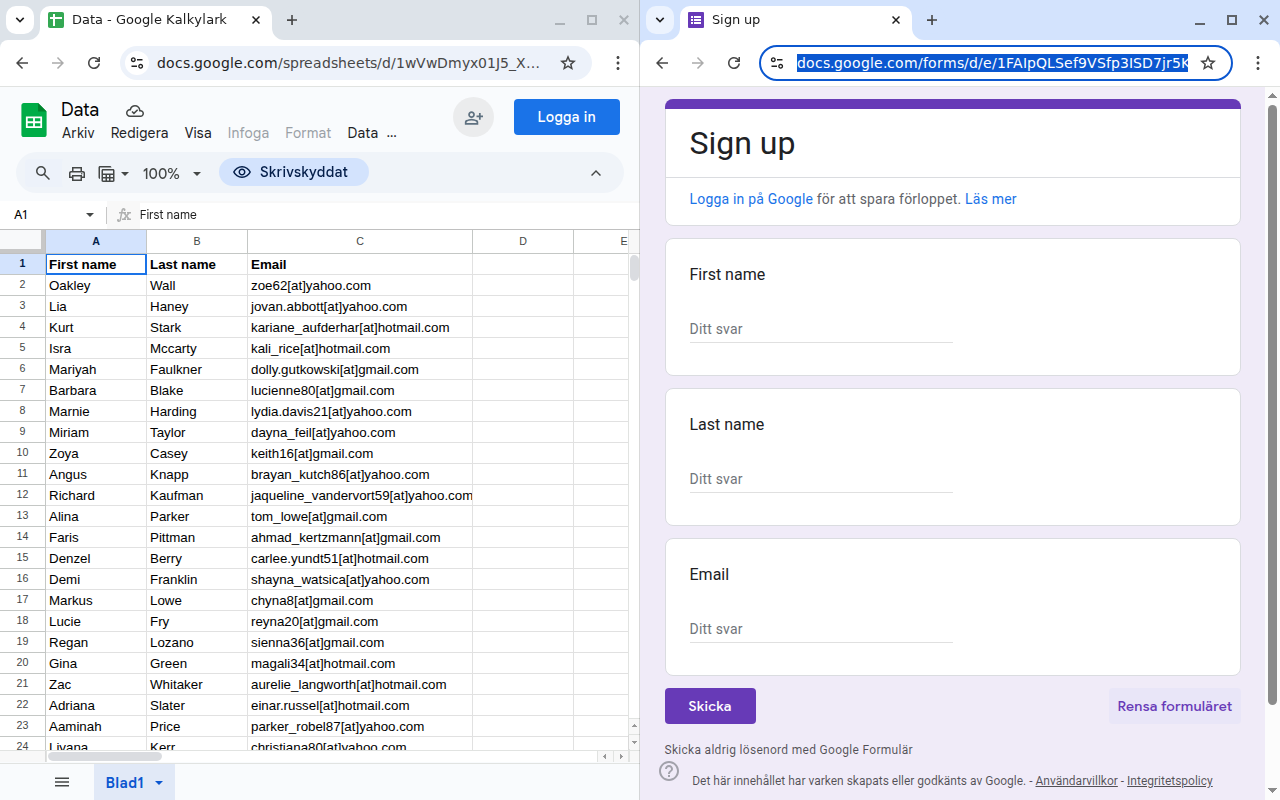
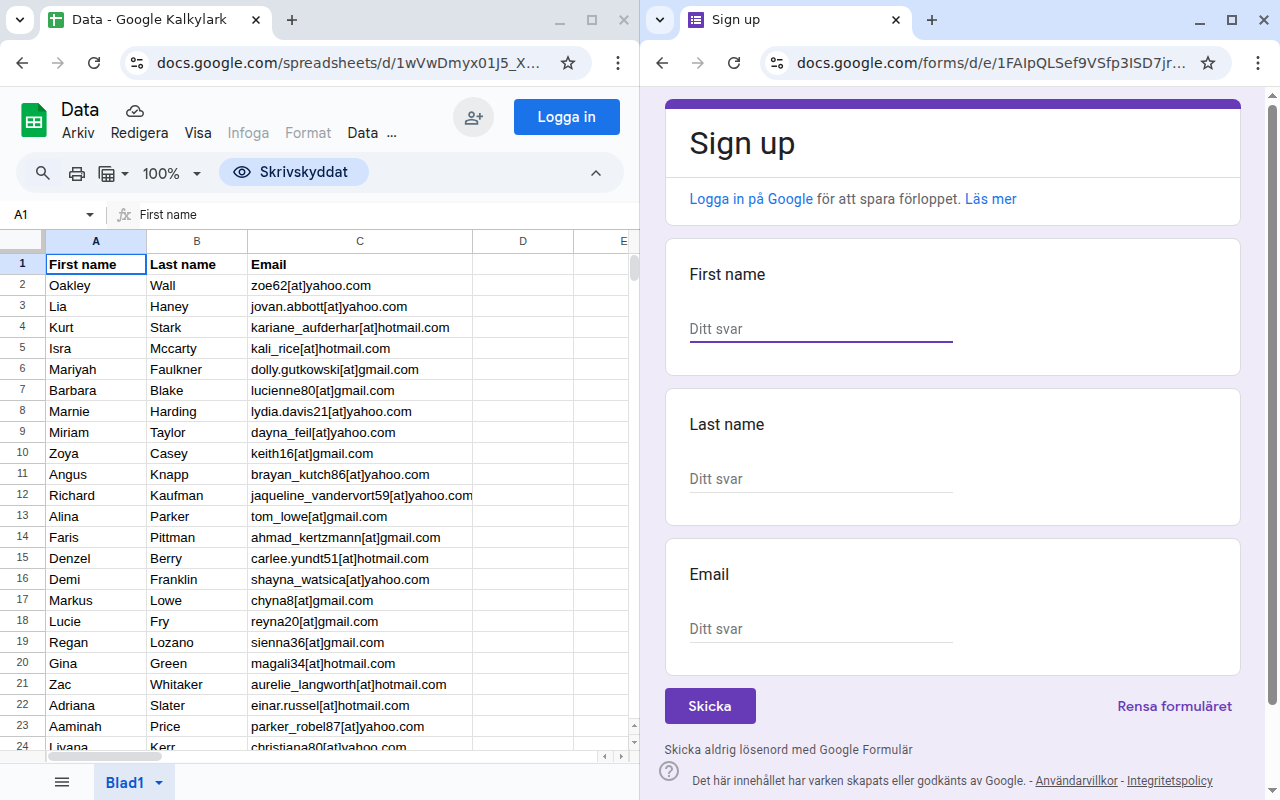

In [27]:
messages

In [28]:
inputs = processor.apply_chat_template(
	messages,
	tokenize=True,
	return_dict=True,
	return_tensors="pt",
).to(model.device)

In [29]:
inputs["labels"] = inputs.input_ids
inputs

{'input_ids': tensor([[151644,   8948,    198,  ...,    863, 151645,    198]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], device='cuda:0'), 'pixel_values': tensor([[1.4340, 1.4340, 1.4340,  ..., 2.1459, 2.1459, 2.1459],
        [1.4340, 1.4340, 1.4340,  ..., 2.1459, 2.1459, 2.1459],
        [1.4340, 1.4340, 1.4340,  ..., 2.1459, 2.1459, 2.1459],
        ...,
        [1.8865, 1.8865, 1.8865,  ..., 2.1032, 2.1032, 2.1032],
        [1.7114, 1.7114, 1.7114,  ..., 2.0464, 2.0464, 2.1032],
        [1.8865, 1.8865, 1.9157,  ..., 2.1032, 2.1032, 2.1032]],
       device='cuda:0'), 'image_grid_thw': tensor([[ 1, 58, 92],
        [ 1, 58, 92]], device='cuda:0'), 'labels': tensor([[151644,   8948,    198,  ...,    863, 151645,    198]],
       device='cuda:0')}

In [30]:
inputs.input_ids.shape

torch.Size([1, 3266])

In [31]:
#from torch.profiler import profile, ProfilerActivity

# 1. Enable memory profiling and capture the forward pass
#with profile(activities=[
#        ProfilerActivity.CPU, 
#        ProfilerActivity.CUDA], 
#    profile_memory=True, 
#    record_shapes=True) as prof:
    
    # Run your problematic forward pass here
    # Ensure your model and input tensors are on the GPU
    #with torch.no_grad():
output = model(reduction="none", **inputs)

# 2. Print a table summarizing the CUDA memory events
#print(prof.key_averages().table(sort_by="cuda_memory_usage", row_limit=15))

# 3. Optional: Export for a visual timeline (see Step 2)
# prof.export_chrome_trace("trace.json")

In [32]:
def find_all_sublists(lst, sub):
    n, m = len(lst), len(sub)
    return [i for i in range(n - m + 1) if lst[i:i+m] == sub]

start_idx = find_all_sublists(inputs.input_ids[0][1:].tolist(), [151644, 77091, 198])[-1] + 3
completion_tokens = inputs.input_ids[0][1:][start_idx:]
completion_loss = output.loss[start_idx:]

In [33]:
ref_tokens = [ref_token['token'] for ref_token in rollout["completions"][completion_idx]["logprobs"]]
ref_logprobs = [ref_token['logprob'] for ref_token in rollout["completions"][completion_idx]["logprobs"]]
print("\n".join(f"{token_id}\t{processor.tokenizer.decode([token_id]).__repr__()}\t{ref_token}\t{-ref_logprob}\t{loss}" for token_id, ref_token, ref_logprob, loss in zip(completion_tokens, ref_tokens, ref_logprobs, completion_loss, )))

84169	'Thought'	Thought	-0.0	-0.0
25	':'	:	-0.0	-0.0
358	' I'	 I	1.0830323696136475	1.072927474975586
3003	"'ve"	've	1.7699675559997559	1.786128044128418
13686	' noticed'	 noticed	1.7576004266738892	1.7540171146392822
429	' that'	 that	0.12172473967075348	0.11222720891237259
279	' the'	 the	0.2038155347108841	0.21253825724124908
1946	' input'	 input	1.383933186531067	1.5412038564682007
3745	' box'	 box	0.14706078171730042	0.14667697250843048
369	' for'	 for	0.6732408404350281	0.7139580249786377
279	' the'	 the	0.06301358342170715	0.06485413014888763
1156	' first'	 first	0.2820205092430115	0.25526270270347595
829	' name'	 name	0.007251963950693607	0.006625588983297348
374	' is'	 is	0.6911093592643738	0.6805012822151184
2669	' already'	 already	0.9800741672515869	0.8899457454681396
4091	' selected'	 selected	1.0671144723892212	1.0523295402526855
11	','	,	0.35898277163505554	0.3563528060913086
773	' so'	 so	0.9798470735549927	1.0321496725082397
358	' I'	 I	1.331368088722229	1.367496490478

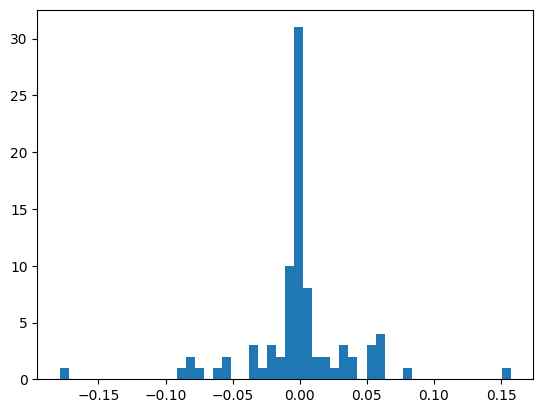

In [34]:
import matplotlib.pyplot as plt
import numpy as np

ref_neg_logprobs = -np.array(ref_logprobs)
completion_loss_np = completion_loss.cpu().detach().numpy()[:-2]

#print(completion_loss_np)

_ = plt.hist(completion_loss_np-ref_neg_logprobs, bins=50)

In [20]:
output.loss.backward()

In [13]:
model.print_trainable_parameters()

trainable params: 5,046,272 || all params: 8,297,212,928 || trainable%: 0.0608


In [19]:
import torch
import gc

def get_gpu_tensors_sorted_by_size(device_id=0):
    """
    Retrieves all PyTorch tensors currently in GPU memory, calculates their size,
    and returns a sorted list of their properties.
    """
    print(f"--- Listing Live PyTorch Tensors on GPU {device_id} ---")
    
    tensor_info = []
    
    # 1. Iterate through all objects tracked by the Python garbage collector
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj) and obj.is_cuda and obj.get_device() == device_id:
                # Calculate size in bytes: element_size * number_of_elements
                size_in_bytes = obj.element_size() * obj.nelement()
                
                tensor_info.append({
                    'size_MB': size_in_bytes / (1024 * 1024),
                    'shape': tuple(obj.size()),
                    'dtype': obj.dtype,
                    'requires_grad': obj.requires_grad,
                    # Optional: Add traceback/origin for more advanced debugging if needed
                })
        except Exception:
            # Safely skip objects that raise an error during property check
            continue

    # 2. Sort the list by size in descending order
    tensor_info.sort(key=lambda x: x['size_MB'], reverse=True)
    
    # 3. Print the sorted list
    print(f"Total Tensors Found: {len(tensor_info)}")
    print("-----------------------------------------------------------------------")
    print(f"{'Size (MB)':<12} {'Shape':<30} {'Dtype':<12} {'Grad':<5}")
    print("-----------------------------------------------------------------------")
    for info in tensor_info[:100]: # Only list the top 20 largest tensors
        size_str = f"{info['size_MB']:<11.3f}"
        shape_str = f"{str(info['shape']):<30}"
        dtype_str = f"{str(info['dtype']).split('.')[-1]:<12}"
        grad_str = f"{str(info['requires_grad']):<5}"
        print(f"{size_str} {shape_str} {dtype_str} {grad_str}")
    
    print("-----------------------------------------------------------------------")

    # Calculate total size in MB of all tensors
    total_size_mb = sum(info['size_MB'] for info in tensor_info)
    print(f"Total size of all tensors: {total_size_mb:.3f} MB")


    return tensor_info

# Example Usage:
# Run this function at the point of your crash (or near it)
_ = get_gpu_tensors_sorted_by_size(device_id=0)

--- Listing Live PyTorch Tensors on GPU 0 ---


/home/tobias/ui-rl/.venv/lib/python3.12/site-packages/torch/__init__.py:1125: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  return isinstance(obj, torch.Tensor)


Total Tensors Found: 920
-----------------------------------------------------------------------
Size (MB)    Shape                          Dtype        Grad 
-----------------------------------------------------------------------
4211.947    (1, 14522, 152064)             bfloat16     True 
1039.500    (152064, 3584)                 bfloat16     False
1039.500    (152064, 3584)                 bfloat16     False
239.377     (53360, 1176)                  float32      False
198.543     (1, 14522, 3584)               float32      True 
143.626     (32016, 1176)                  float32      False
129.500     (18944, 3584)                  bfloat16     False
129.500     (18944, 3584)                  bfloat16     False
129.500     (3584, 18944)                  bfloat16     False
129.500     (18944, 3584)                  bfloat16     False
129.500     (18944, 3584)                  bfloat16     False
129.500     (3584, 18944)                  bfloat16     False
129.500     (18944, 3584